# ESTIMANDO A QUALIDADE DE VINHOS

O objetivo deste experimento é de treinar um modelo que seja capaz de estimar com eficácia a qualidade do vinho perante as caracteristicas físico-químicas apresentadas, e identificar as varáveis que mais impactam na qualidade do vinho.

O presente documento é dividido em:
1. Bibliotecas e Constantes
2. Dados
3. Consistencia dos Dados e Limpeza

## 1. Bibliotecas e Constantes

In [11]:
# manipulacao e visualizacao
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import style
from scipy import stats

# configurando visualizacao
% matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='darkgrid', color_codes=True)

# Para ignorar os avisos
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# regressao
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# classificacao
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# selecao do melhor modelo
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# preprocessamento
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Imputer, LabelEncoder

# metricas
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# selecao de features
from sklearn.feature_selection import mutual_info_classif

# para reprodutibilidade
SEED = 667

# variaveis e tipos
# dado que queremos prever a qualidade do vinho, a feature 'quality' é o label
LABEL_COLUMNS = ['quality']
# e todo resto são nossas features de treinamento
TRAIN_COLUMNS = ['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
    'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

TYPE_COLUMNS = {
    'type':'category',
    'fixed acidity': np.float32,
    'volatile acidity': np.float32,
    'citric acid': np.float32,
    'residual sugar': np.float32,
    'chlorides': np.float32,
    'free sulfur dioxide': np.float32,
    'total sulfur dioxide': np.float32,
    'density': np.float32,
    'pH': np.float32,
    'sulphates': np.float32
}

## 2. Dados

**Variáveis e seus tipos (baseado em testes físico-químicos):***

Coluna | Significado | Tipo
--- | --- | ---
type | Tipo de Vinho | Categorica
fixed acidity | Acidez fixa | Numérica Ordinal
volatile acidity | Volatilidade da acidez | Numérica Ordinal
citric acid | Ácido cítrico | Numérica Ordinal
residual sugar | Açúcar residual | Numérica Ordinal
chlorides | Cloretos | Numérica Ordinal
free sulfur dioxide | Dióxido de enxofre livre | Numérica Ordinal
total sulfur dioxide | Dióxido de enxofre total | Numérica Ordinal
density | Densidade | Numérica Ordinal
pH | pH | Numérica Ordinal
sulphates | Sulfatos | Numérica Ordinal
quality | Qualidade do Vinho | Numérica Ordinal

### 2.1 Leitura dos dados

In [115]:
data = pd.read_csv('../input/winequality.csv', sep=';')

### 2.2 Informações básicas

In [116]:
null_rows = data.isnull().sum(axis=1).sum()
dupl_rows = data.duplicated().sum()

In [117]:
print("O dataset possui {0} features diferentes;".format(data.shape[1]))
print("O dataset possui {0} registros;".format(data.shape[0]))
print("O dataset possui {0} registros com valores nulos;".format(null_rows))
print("O dataset possui {0} registros duplicados".format(dupl_rows))
print("E portanto também possui {0} registros diferentes".format(data.shape[0] - dupl_rows))

O dataset possui 13 features diferentes;
O dataset possui 6497 registros;
O dataset possui 0 registros com valores nulos;
O dataset possui 1177 registros duplicados
E portanto também possui 5320 registros diferentes


## 3. Limpeza e Consistencia dos Dados

### 3.1. Retirada de duplicatas

Como o conjunto de dados apresentou registros duplicados, é importante que eles sejam retirados para que determinados modelos a serem treinados, não sejam influenciados a considera-los mais importantes do que outros.

In [118]:
data = data[~data.duplicated()]

### 3.2. Análise Univariada

As vezes apesar de haver valores nos registros, por conta de erros no momento da ingestão ou captação dos dados, estes valores divergem muito da distribuição da variavel em si, por vezes tornando o valor impossível para a variável em questão. Estes casos podem dificultar a adequação do modelo preditivo, e é por isso que devesse identifica-los e trata-los.

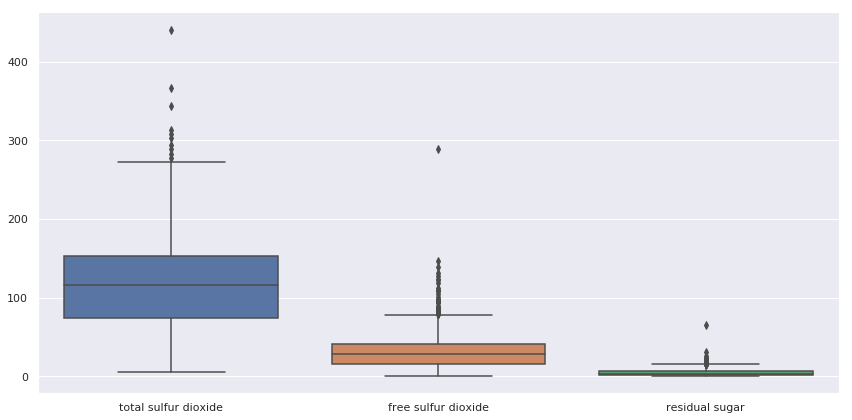

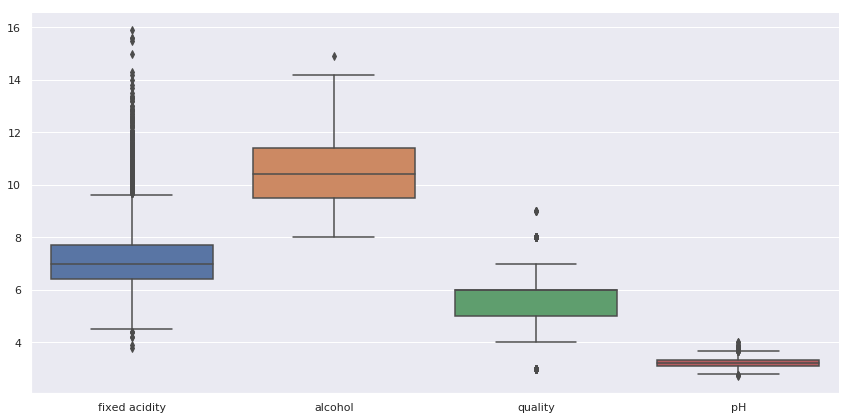

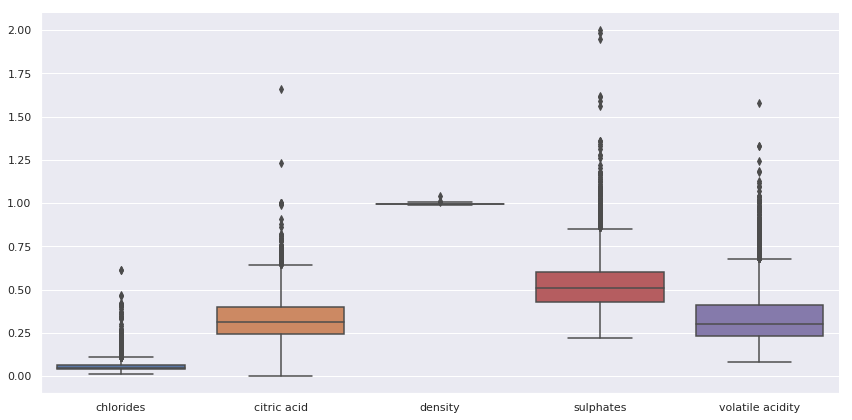

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000
mean,0.744549,7.215179,0.344130,0.318494,5.048477,0.056690,30.036654,114.109023,0.994535,3.224664,0.533357,10.549214,5.795677
std,0.436155,1.319671,0.168248,0.147157,4.500180,0.036863,17.805045,56.774223,0.002966,0.160379,0.149743,1.185922,0.879772
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,0.000000,6.400000,0.230000,0.240000,1.800000,0.038000,16.000000,74.000000,0.992200,3.110000,0.430000,9.500000,5.000000
50%,1.000000,7.000000,0.300000,0.310000,2.700000,0.047000,28.000000,116.000000,0.994650,3.210000,0.510000,10.400000,6.000000
75%,1.000000,7.700000,0.410000,0.400000,7.500000,0.066000,41.000000,153.250000,0.996770,3.330000,0.600000,11.400000,6.000000
max,1.000000,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [198]:
column_scale_1 = ['total sulfur dioxide', 'free sulfur dioxide', 'residual sugar']
column_scale_2 = ['fixed acidity', 'alcohol', 'quality', 'pH']
column_scale_3 = ['chlorides', 'citric acid', 'density', 'sulphates', 'volatile acidity']

sns.factorplot(data=data[column_scale_1], kind='box',size=6,aspect=2)
sns.factorplot(data=data[column_scale_2], kind='box',size=6,aspect=2)
sns.factorplot(data=data[column_scale_3], kind='box',size=6,aspect=2)
plt.show()

# metricas
data.describe(include='all')

Olhando para o gráfico e a tabela acima, é possível observar que algumas features podem conter valores errados

* residual sugar - O valor máximo está muito acima do valor que divide o terceiro quartil;
* free sulfur dioxide - O valor máximo está muito acima do valor que divide o terceiro quartil;
* density - O valor máximo está muito acima do valor que divide o terceiro quartil;
* alcohol - Não foi possível nem calcular as métricas, talvez possua um valor não numérico.



### 3.3. Identificação de Outliers
#### Limpando _alcohol_:

In [120]:
# pegando os valores "normais"
filter_alcohol = data['alcohol'].apply(lambda x: len(x) > 5)

print("Valores anormais {0}".format(data['alcohol'][filter_alcohol].unique()))
print("Valor máximo de alcohol {0}".format(data['alcohol'][~filter_alcohol].astype(float).max()))
print("Valor mínimo de alcohol {0}".format(data['alcohol'][~filter_alcohol].astype(float).min()))

Valores anormais ['128.933.333.333.333' '114.666.666.666.667' '100.333.333.333.333'
 '114.333.333.333.333' '105.333.333.333.333' '953.333.333.333.333'
 '109.333.333.333.333' '113.666.666.666.667' '113.333.333.333.333'
 '110.666.666.666.667' '973.333.333.333.333' '123.333.333.333.333'
 '112.666.666.666.667' '105.666.666.666.667' '117.333.333.333.333'
 '109.666.666.666.667' '101.333.333.333.333' '104.666.666.666.667'
 '116.333.333.333.333' '131.333.333.333.333' '120.666.666.666.667'
 '963.333.333.333.333' '956.666.666.666.667' '135.666.666.666.667'
 '923.333.333.333.333']
Valor máximo de alcohol 14.9
Valor mínimo de alcohol 8.0


Dado que os valores considerados _"normais"_ estão entre os valores 8 e 14.9, e os valores anormais começam com o dígito 1 e 9 seguido de repetições de dígitos, é bastante provável que ocorreu um erro de pontuação nestes valores.

In [121]:
# limpando a features alcohol
def convert_alcohol(x):
    if len(str(x)) <= 5:
        return x

    converted_value = str(x).replace('.', '')
    first_digit = converted_value[0][0]
    
    if int(first_digit) == 1:
        converted_value = float(converted_value[:2] + '.' + converted_value[2:4])
    else:
        converted_value = float(converted_value[:1] + '.' + converted_value[1:3])
    return converted_value

data['alcohol'] = data['alcohol'].apply(lambda x: convert_format(x))

A partir daqui, todas as features podem ser consideradas numéricas, podendo ser alteradas no dataframe:

In [122]:
data.loc[:, data.columns != 'type'] = data.loc[:, data.columns != 'type'].astype(float)

#### Limpando a feature _density_:

Dado que o objeto de estudo é um líquido, seguindo conceitos da física, o vinho não pode ter densidade muito grande, por conta disso é provavel que os valores acima de 10 podem ter sido comprometidos por erro de formatação, assim como a feature _alcohol_.
Dado essa premissa, podemos inserir este passo no préprocessamento dessa variável, assim como o álcool.

In [125]:
def convert_density(x):
    if x < 5:
        return x

    converted_value = str(x).replace('.', '')
    first_digit = converted_value[0][0]
    
    if int(first_digit) == 1:
        converted_value = float(converted_value[:1] + '.' + converted_value[1:])
    else:
        converted_value = float(0 + '.' + converted_value)
    return converted_value

data['density'] = data['density'].apply(lambda x: convert_density(x))

#### Olhando para  _residual sugar_, _total sulfur dioxide_ e _free sulfur dioxide_:

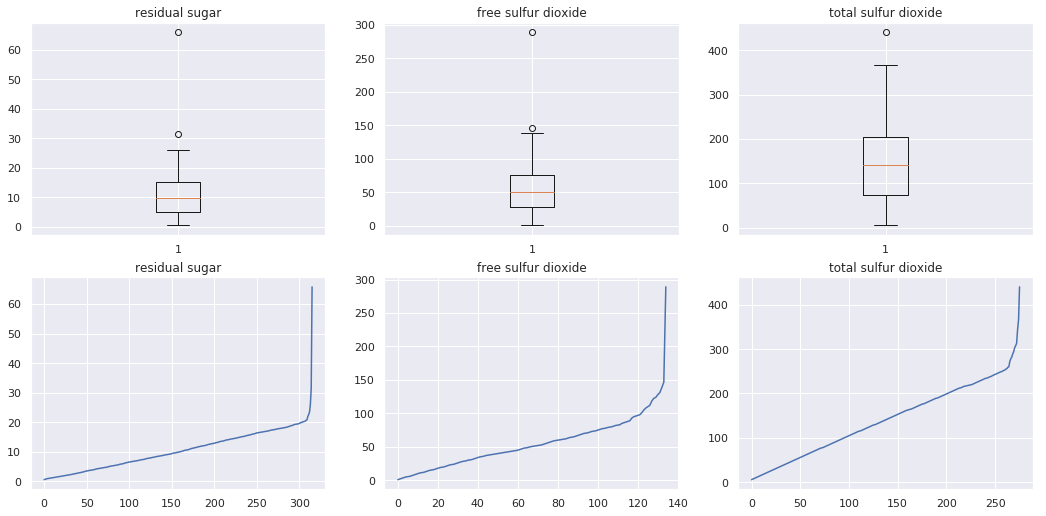

In [129]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16, 8))

df_rs = sorted(data['residual sugar'].unique())
df_fsd = sorted(data['free sulfur dioxide'].unique())
df_tsd = sorted(data['total sulfur dioxide'].unique())

# boxplots
ax1.set_title('residual sugar')
ax1.boxplot(df_rs)

ax2.set_title('free sulfur dioxide')
ax2.boxplot(df_fsd)

ax3.set_title('total sulfur dioxide')
ax3.boxplot(df_tsd)

# linearplots
ax4.set_title('residual sugar')
ax4.plot(df_rs)

ax5.set_title('free sulfur dioxide')
ax5.plot(df_fsd)

ax6.set_title('total sulfur dioxide')
ax6.plot(df_tsd)

plt.show()

Diferente do caso do _alcohol_, que continha valores que impediam que a variável fosse considerada númerica, ou da feature _density_ que existe um fenômeno físico que explica a incongruência, as features seguintes apresentam valores de mesmo tipo e cabíveis, sendo o único notável a diferença do resto da distribuição, que de certo modo pode comprometer a performace do modelo preditivo.

__Dado isso, cabe a pergunta, o que fazer com eles?__

Muitos defendem alterar estes valores para a média ou mediana da distribuição, encontrar um registro que contenha as outras features similiares e copiar o valor correspondente, ou até mesmo exclui-los. Entretanto estes valores refletem o comportamento da formação dos dados, e como o objetivo de modelos majoritariamente é de prever resultados para casos que ainda não aconteceram, ou seja não estão no conjunto de dados de teste, é importante que ele tenha a capacidade de lidar com estes casos considerados _"Outliers"_ sem que haja um preprocessamento, até porque qualquer presunção a respeito dos dados é assumir riscos, e esse risco é propagado para o modelo, por vezes comprometendo a qualidade deste.

Dado isso, não será alterado qualquer outro valor.

Abaixo as métricas atuais.

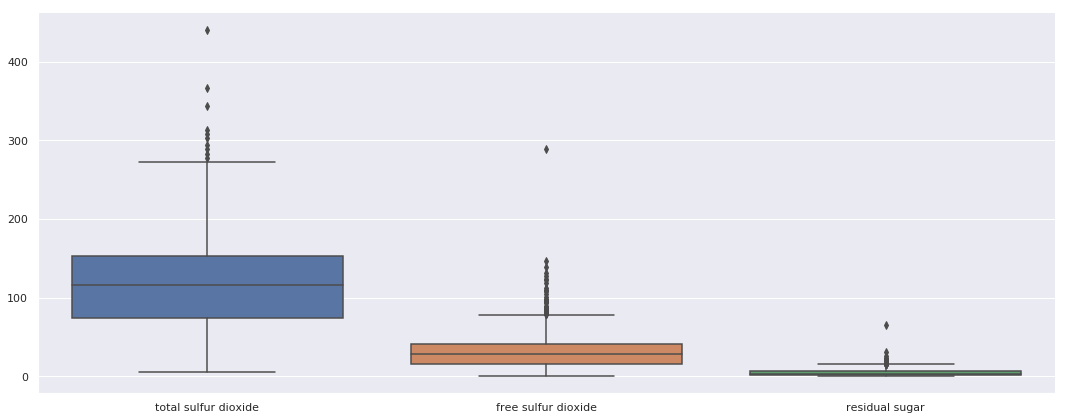

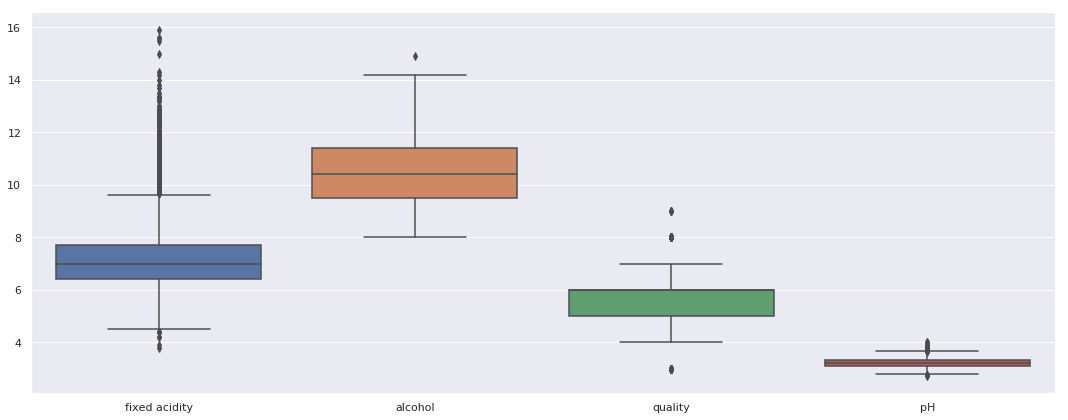

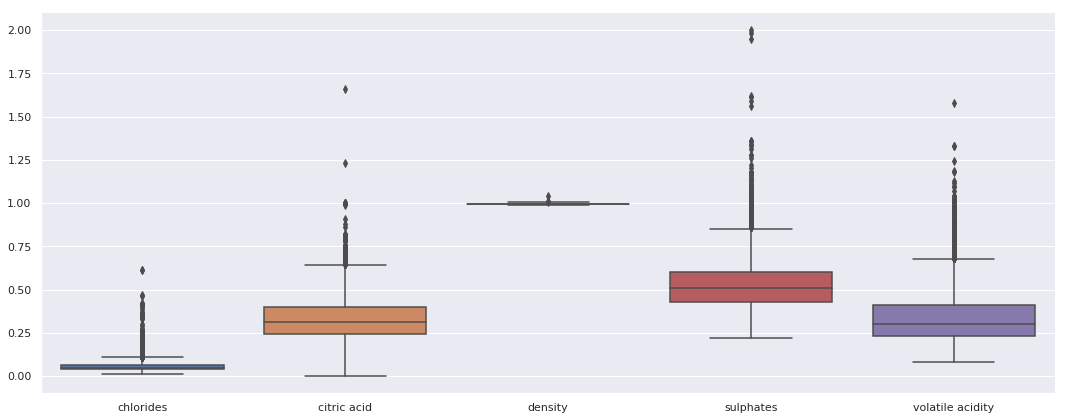

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000
mean,0.744549,7.215179,0.344130,0.318494,5.048477,0.056690,30.036654,114.109023,0.994535,3.224664,0.533357,10.549214,5.795677
std,0.436155,1.319671,0.168248,0.147157,4.500180,0.036863,17.805045,56.774223,0.002966,0.160379,0.149743,1.185922,0.879772
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,0.000000,6.400000,0.230000,0.240000,1.800000,0.038000,16.000000,74.000000,0.992200,3.110000,0.430000,9.500000,5.000000
50%,1.000000,7.000000,0.300000,0.310000,2.700000,0.047000,28.000000,116.000000,0.994650,3.210000,0.510000,10.400000,6.000000
75%,1.000000,7.700000,0.410000,0.400000,7.500000,0.066000,41.000000,153.250000,0.996770,3.330000,0.600000,11.400000,6.000000
max,1.000000,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [199]:
sns.factorplot(data=data[column_scale_1], kind='box',size=6,aspect=2.5)
sns.factorplot(data=data[column_scale_2], kind='box',size=6,aspect=2.5)
sns.factorplot(data=data[column_scale_3], kind='box',size=6,aspect=2.5)
plt.show()

# metricas
data.describe(include='all')

## 4. Análise Multivariada

### 4.1. Similaridade entre features

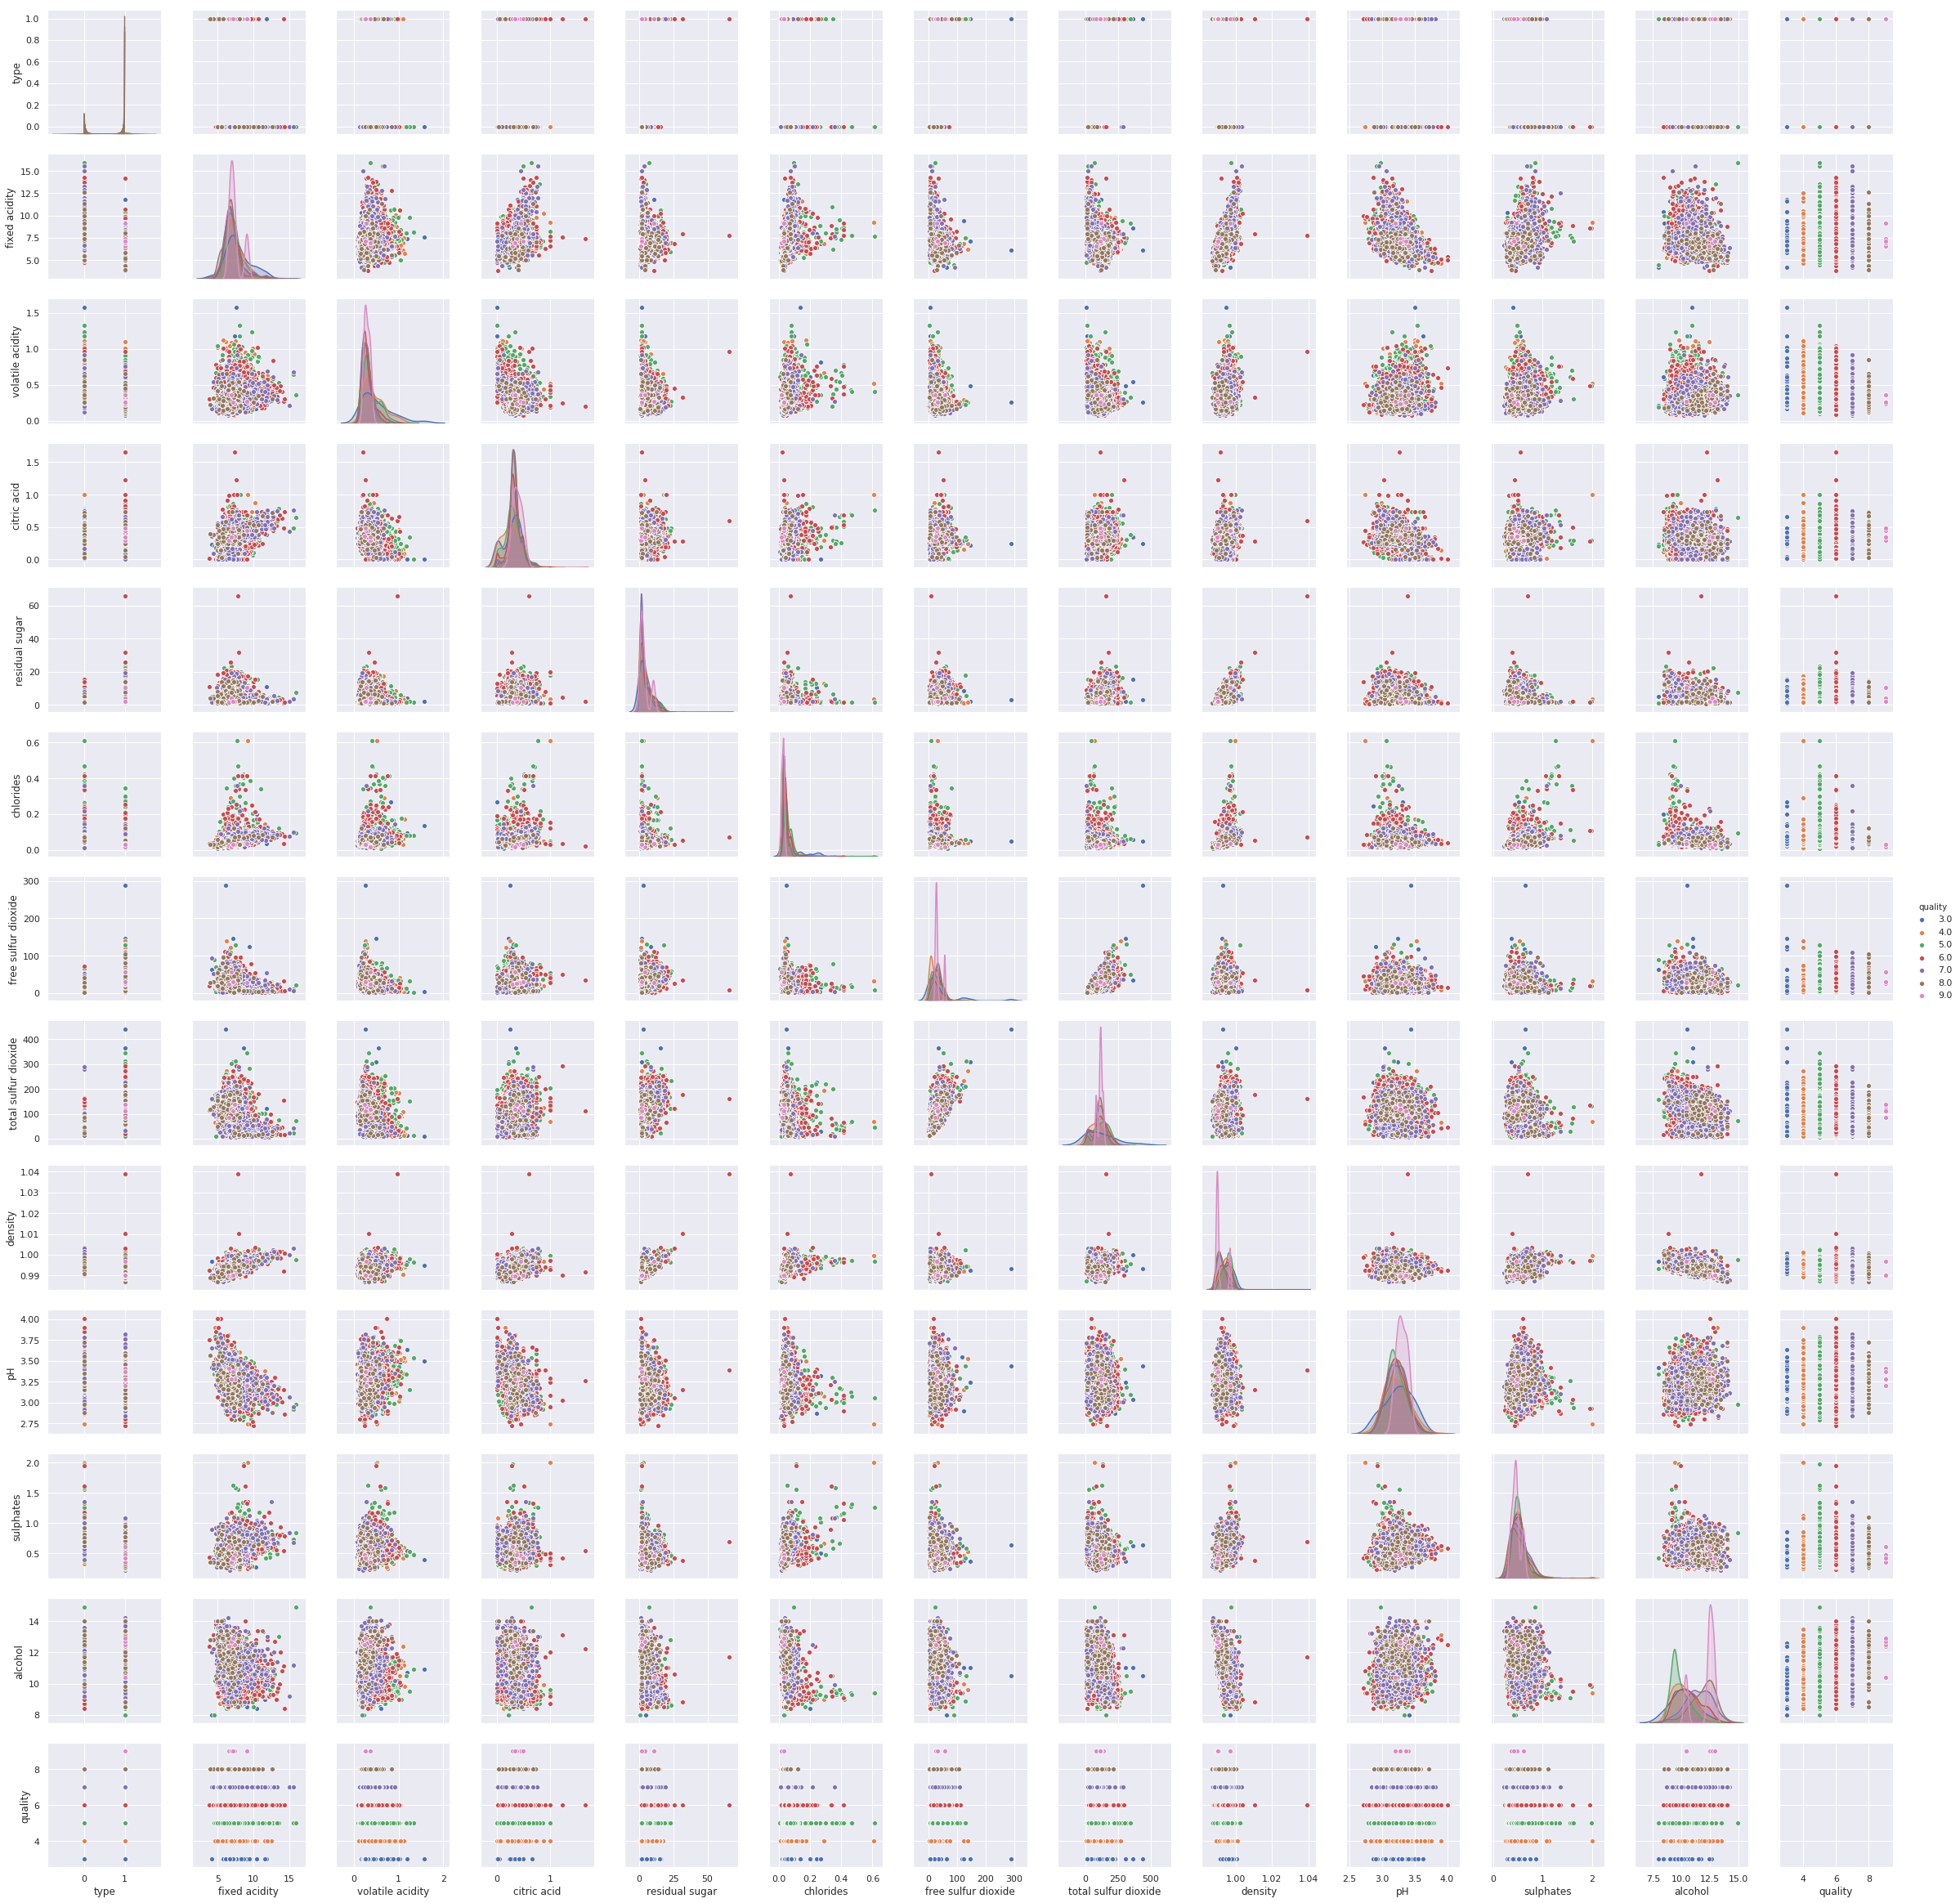

In [182]:
sns.pairplot(data, hue="quality")
plt.show()

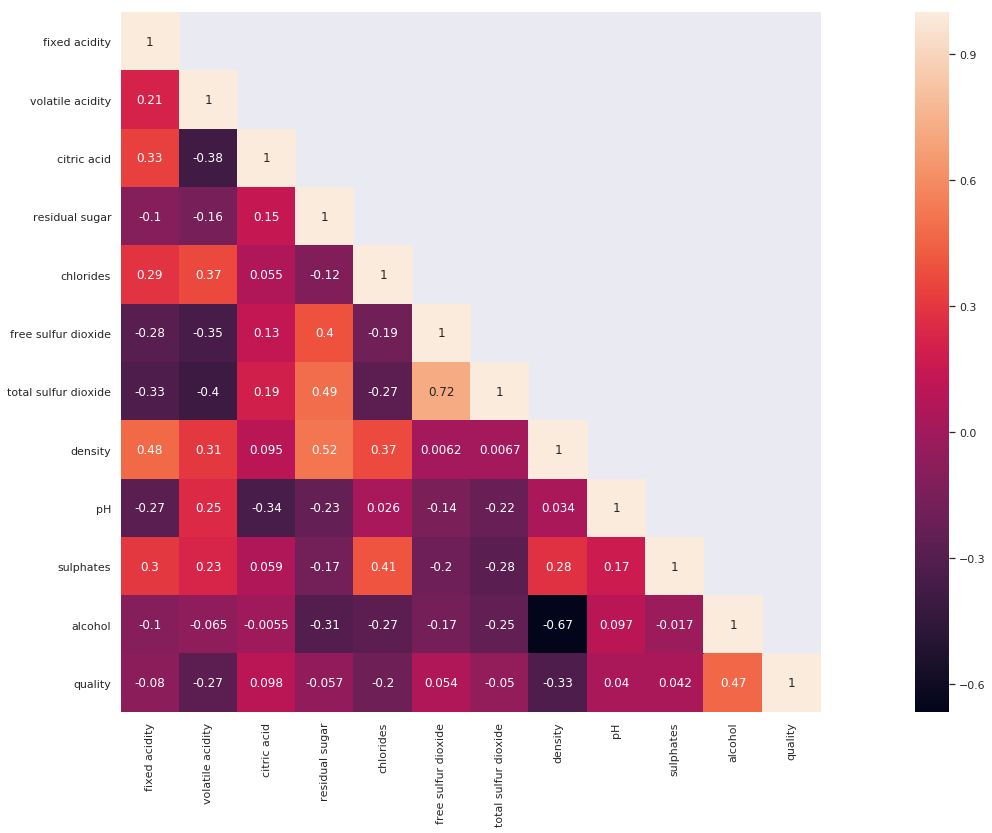

In [148]:
cor_mat= data.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

plt.show()

Segundo a matriz de correlação(coeficiente de Pearson), e o gráfico de pares acima, podesse definir a hipótese que:
* A quantidade de alcool é uma característica importante para a qualidade;
* A densidade é uma característica importante para a qualidade;
* A acidez volátil é uma característica importante para a qualidade.

Além de outras relações que podem ser problematicas para o modelo, dado que podem estar descrevendo o mesmo fenômeno, como entre:
* _total sulfur dioxide_ ,  _free sulfur dioxide_ e _residual sugar_;
* _sulphates_ e _chlorides_;
* _density_ e _residual sugar_;
* _density_ e _fixed acidity_.

Aplicando o conceito de [Informação Mútual](https://en.wikipedia.org/wiki/Mutual_information), que usa de entropia para medir depêndencia mútua:


In [176]:
columns_mutual = data.columns.difference(['type', 'quality'])

data_mutual = mutual_info_classif(data[columns_mutual], data['quality'], n_neighbors=5, random_state=SEED)

idx = 0
for column in columns_mutual:
    print("{} : {}".format(column, data_mutual[idx]))
    idx = idx+1

alcohol : 0.15650203534974505
chlorides : 0.0635719069101972
citric acid : 0.029738696329252523
density : 0.09329436499375143
fixed acidity : 0.009689439699002378
free sulfur dioxide : 0.013211438168558853
pH : 0.010497981961757663
residual sugar : 0.02745222749539833
sulphates : 0.012141474258782647
total sulfur dioxide : 0.046264711037070416
volatile acidity : 0.048589449490606285


É possível tirar as mesmas conclusões das análises anteriores, com um adendo que a feature _chlorides_ obteve um valor maior que _volatile acidity_, que indica que _chlorides_ também seja uma feature que seja importante para a definição da qualidade do vinho.

## 5. Modelagem

### 5.1 Préprocessamento
Para modelagem precisamos mudar a feature _type_ de categorica para binária.

In [180]:
convert_bin = {
    "White": 1,
    "Red": 0
}
data['type'] = data['type'].replace(convert_bin)

### 5.2 Modelo Base

Treinamento de um modelo mais simples possível para comparação